# <center> <font color=#102C54> <i> Transformers - Trading </font> </center> </i>

<img style="float: left;;" src='https://upload.wikimedia.org/wikipedia/commons/d/db/Logo_ITESO_normal.jpg' width="80" height="160"/></a>
    
<i><center> **Trading Microstructure**  
    <center> Claudia Valeria Chimal Parra 
    <center> Paulo Cesar Ayala Gutiérrez
    <center> Juan Carlos Gutiérrez Valdivia
    <center> Oscar Leonardo Vaca González
    <center> Arturo Espinosa Carabez
        
   <center> May 5th, 2024 

# Classification With Transformers

In [32]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta
import warnings

warnings.filterwarnings('ignore')

In [33]:
data_train = pd.read_csv("./data/aapl_5m_train.csv").dropna()
data_test = pd.read_csv("./data/aapl_5m_test.csv").dropna()

In [37]:
data_train

,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,1609770600,0,04/01/2021 14:30,133.570007,133.611602,132.389999,132.809997,6624663.0
1,1609770900,0,04/01/2021 14:35,132.750000,132.750000,131.809997,131.889999,2541553.0
2,1609771200,0,04/01/2021 14:40,131.500000,132.339996,131.500000,132.059997,2492415.0
3,1609771500,0,04/01/2021 14:45,132.000000,132.250000,131.899993,132.250000,1859131.0
4,1609771800,0,04/01/2021 14:50,132.000000,132.018096,131.520004,131.589996,1780105.0
...,...,...,...,...,...,...,...,...
39573,1672432500,0,30/12/2022 20:35,129.020004,129.050003,128.899993,129.039993,773964.0
39574,1672432800,0,30/12/2022 20:40,129.029998,129.130004,128.919998,129.054992,833767.0
39575,1672433100,0,30/12/2022 20:45,129.059997,129.399993,129.020004,129.380004,2136910.0
39576,1672433400,0,30/12/2022 20:50,129.375000,129.929992,129.330001,129.764404,2879267.0


## Normalizing Data

In [ ]:
train_mean = data_train.loc[:, ["Open", "High", "Low", "Close"]].mean()
train_std = data_train.loc[:, ["Open", "High", "Low", "Close"]].std()

norm_data_train = (data_train.loc[:, ["Open", "High", "Low", "Close"]] - train_mean) / train_std
norm_data_test = (data_test.loc[:, ["Open", "High", "Low", "Close"]] - train_mean) / train_std

## Generating our features

In [29]:
# RSI configurations
rsi_params = {
    'window': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
}

# WMA (Weighted Moving Average) configurations
wma_params = {
    'window': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
}

# MACD configurations
macd_params = {
    'fast_period': [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
    'slow_period': [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    'signal_period': [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
}

# Bollinger Bands configurations
boll_params = {
    'window': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
    'window_dev': [2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 3.2, 3.3, 3.4]
}


In [30]:
# Normalizing
def normalize(data, column_name):
    return (data[column_name] - data[column_name].mean()) / data[column_name].std()

for i in range(15):  # Cambia el rango según el número de configuraciones que desees procesar
    # RSI
    data_train[f'rsi_{i}'] = ta.momentum.RSIIndicator(data_train['Close'], window=rsi_params['window'][i]).rsi()
    data_test[f'rsi_{i}'] = ta.momentum.RSIIndicator(data_test['Close'], window=rsi_params['window'][i]).rsi()

    # WMA
    data_train[f'wma_{i}'] = ta.trend.WMAIndicator(data_train['Close'], window=wma_params['window'][i]).wma()
    data_test[f'wma_{i}'] = ta.trend.WMAIndicator(data_test['Close'], window=wma_params['window'][i]).wma()

    # MACD
    macd = ta.trend.MACD(data_train['Close'], window_fast=macd_params['fast_period'][i], window_slow=macd_params['slow_period'][i], window_sign=macd_params['signal_period'][i])
    data_train[f'macd_{i}'] = macd.macd()
    data_test[f'macd_{i}'] = ta.trend.MACD(data_test['Close'], window_fast=macd_params['fast_period'][i], window_slow=macd_params['slow_period'][i], window_sign=macd_params['signal_period'][i]).macd()

    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(data_train['Close'], window=boll_params['window'][i], window_dev=boll_params['window_dev'][i])
    data_train[f'bollinger_mavg_{i}'] = bollinger.bollinger_mavg()
    data_train[f'bollinger_hband_{i}'] = bollinger.bollinger_hband()
    data_train[f'bollinger_lband_{i}'] = bollinger.bollinger_lband()

    bollinger_test = ta.volatility.BollingerBands(data_test['Close'], window=boll_params['window'][i], window_dev=boll_params['window_dev'][i])
    data_test[f'bollinger_mavg_{i}'] = bollinger_test.bollinger_mavg()
    data_test[f'bollinger_hband_{i}'] = bollinger_test.bollinger_hband()
    data_test[f'bollinger_lband_{i}'] = bollinger_test.bollinger_lband()

    # Normalize each new indicator and concatenate
    for col in [f'rsi_{i}', f'wma_{i}', f'macd_{i}', f'bollinger_mavg_{i}', f'bollinger_hband_{i}', f'bollinger_lband_{i}']:
        data_train[col] = normalize(data_train, col)
        data_test[col] = normalize(data_test, col)
        norm_data_train = pd.concat([norm_data_train, data_train[col]], axis=1)
        norm_data_test = pd.concat([norm_data_test, data_test[col]], axis=1)


KeyboardInterrupt: 

In [8]:
norm_data_train.dropna(inplace=True)
norm_data_test.dropna(inplace=True)

In [9]:
# Export data_train to a CSV file
norm_data_train.to_csv("data_train.csv", index=False)

# Export data_test to a CSV file
norm_data_test.to_csv("data_test.csv", index=False)

In [34]:
norm_data_train = pd.read_csv("data_train.csv")

norm_data_test = pd.read_csv("data_test.csv")

In [111]:
lags = 5

X_train = pd.DataFrame()
X_test = pd.DataFrame()

for lag in range(lags):
    # Add original features with lags
    X_train[f"Close_{lag}"] = norm_data_train.Close.shift(lag)
    
    X_test[f"Close_{lag}"] = norm_data_test.Close.shift(lag)

for i in range(15):  # Suponiendo que tienes 15 configuraciones de cada indicador
    X_train[f'rsi_{i}'] = norm_data_train[f'rsi_{i}']
    X_train[f'wma_{i}'] = norm_data_train[f'wma_{i}']
    X_train[f'macd_{i}'] = norm_data_train[f'macd_{i}']
    X_train[f'bollinger_mavg_{i}'] = norm_data_train[f'bollinger_mavg_{i}']

    X_test[f'rsi_{i}'] = norm_data_test[f'rsi_{i}']
    X_test[f'wma_{i}'] = norm_data_test[f'wma_{i}']
    X_test[f'macd_{i}'] = norm_data_test[f'macd_{i}']
    X_test[f'bollinger_mavg_{i}'] = norm_data_test[f'bollinger_mavg_{i}']
    

    

# Cálculo de las variables objetivo para el entrenamiento y prueba
Y_train = np.where(X_train['Close_0'].shift(-5) > X_train['Close_0'] * (1.01), 2,
                   np.where(X_train['Close_0'].shift(-5) < X_train['Close_0'] * (0.97), 1, 0))
Y_train = pd.DataFrame(Y_train, index=X_train.index)

Y_test = np.where(X_test['Close_0'].shift(-5) > X_test['Close_0'] * (1.01), 2,
                  np.where(X_test['Close_0'].shift(-5) < X_test['Close_0'] * (0.97), 1, 0))
Y_test = pd.DataFrame(Y_test, index=X_test.index)

# Removing NaNs and the last value due to shifting
#X_train.dropna(inplace=True)
copy_train = X_train.copy()
copy_test = X_test.copy()
#X_test.dropna(inplace=True)
X_train = X_train.iloc[lags:-1, :].values
X_test = X_test.iloc[lags:-1, :].values

Y_train = Y_train.iloc[lags:-1].values.reshape(-1, 1)
Y_test = Y_test.iloc[lags:-1].values.reshape(-1, 1)

In [112]:
copy_train

,Close_0,Close_1,Close_2,Close_3,Close_4,rsi_0,wma_0,macd_0,bollinger_mavg_0,rsi_1,...,macd_12,bollinger_mavg_12,rsi_13,wma_13,macd_13,bollinger_mavg_13,rsi_14,wma_14,macd_14,bollinger_mavg_14
0,-1.200793,NaN,NaN,NaN,NaN,0.519478,-1.205338,0.174839,-1.216168,0.432683,...,-0.233070,-1.220897,-1.035407,-1.223511,-0.274634,-1.222322,-1.110755,-1.220308,-0.316063,-1.223477
1,-1.191753,-1.200793,NaN,NaN,NaN,0.912226,-1.199656,0.225947,-1.214004,0.698380,...,-0.185195,-1.219170,-0.910366,-1.223339,-0.226625,-1.220167,-0.985497,-1.220465,-0.267966,-1.221576
2,-1.190456,-1.191753,-1.200793,NaN,NaN,0.966768,-1.195392,0.267914,-1.212307,0.736413,...,-0.140576,-1.217836,-0.892457,-1.223078,-0.181677,-1.218452,-0.967564,-1.220510,-0.222751,-1.219446
3,-1.192399,-1.190456,-1.191753,-1.200793,NaN,0.754339,-1.193369,0.291043,-1.211144,0.640173,...,-0.104143,-1.216513,-0.914260,-1.222828,-0.144506,-1.217218,-0.989121,-1.220552,-0.184931,-1.217839
4,-1.122665,-1.192399,-1.190456,-1.191753,-1.200793,2.028895,-1.169519,0.546841,-1.206685,1.956540,...,0.039189,-1.213604,-0.028221,-1.220571,-0.005509,-1.213819,-0.100122,-1.218693,-0.049955,-1.214587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39081,-1.216289,-1.217580,-1.224683,-1.222746,-1.225967,1.556466,-1.220105,0.385375,-1.254636,1.454381,...,0.059102,-1.254271,0.123135,-1.251203,0.040925,-1.253442,0.098348,-1.251961,0.023738,-1.253047
39082,-1.215321,-1.216289,-1.217580,-1.224683,-1.222746,1.595960,-1.218061,0.424076,-1.251647,1.486791,...,0.100453,-1.253867,0.134938,-1.250273,0.081562,-1.253246,0.109625,-1.251084,0.063634,-1.252476
39083,-1.194336,-1.215321,-1.216289,-1.217580,-1.224683,2.075965,-1.209731,0.522100,-1.247511,2.034248,...,0.169573,-1.252655,0.385387,-1.248787,0.148740,-1.252217,0.349348,-1.249640,0.128940,-1.251668
39084,-1.169516,-1.194336,-1.215321,-1.216289,-1.217580,2.262051,-1.195020,0.678735,-1.242295,2.407139,...,0.268756,-1.250686,0.664777,-1.246638,0.244756,-1.250289,0.618022,-1.247560,0.221944,-1.249939


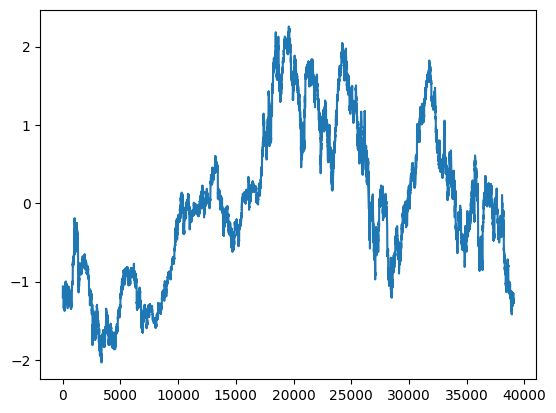

In [113]:
plt.plot(copy_train.index, copy_train.Close_0)

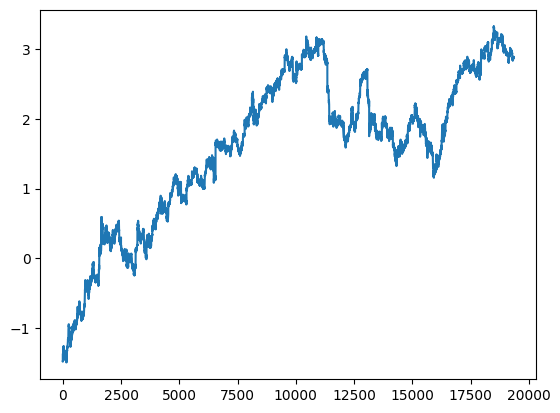

In [114]:
plt.plot(copy_test.index, copy_test.Close_0)

In [115]:
Y_train_valid = pd.DataFrame(Y_train)
Y_test_valid = pd.DataFrame(Y_test)
print(Y_train_valid.value_counts())
print(Y_test_valid.value_counts())

2    20502
1    12259
0     6319
Name: count, dtype: int64
0    11719
2     5479
1     2146
Name: count, dtype: int64


## Reshaping Tensors

In [116]:
features = X_train.shape[1]

X_train = X_train.reshape(-1, features, 1)
X_test = X_test.reshape(-1, features, 1)

## Classification Model

In [14]:
def create_transformer(inputs, head_size, num_heads, dnn_dim):
    # Stacking layers
    l1 = tf.keras.layers.MultiHeadAttention(key_dim=head_size,
                                            num_heads=num_heads,
                                            dropout=0.2)(inputs, inputs)
    l2 = tf.keras.layers.Dropout(0.2)(l1)
    l3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(l2)
    
    res = l3 + inputs
    
    # Traditional DNN
    l4 = tf.keras.layers.Conv1D(filters=4, kernel_size=1, activation="relu")(res)
    l5 = tf.keras.layers.Dropout(0.2)(l4)
    l6 = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(l5)
    l7 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(l6)
    return l7 + res

In [15]:
input_shape = X_train.shape[1:]

# Hyperparams
head_size = 256
num_heads = 4
num_transformer_blocks = 4
dnn_dim = 4
units = 128


# Defining input_shape as Input layer
input_layer = tf.keras.layers.Input(input_shape)

# Creating our transformers based on the input layer
transformer_layers = input_layer

for _ in range(num_transformer_blocks):
    # Stacking transformers
    transformer_layers = create_transformer(inputs=transformer_layers,
                                            head_size=head_size,
                                            num_heads=num_heads,
                                            dnn_dim=dnn_dim)

# Adding global pooling
pooling_layer = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_last")\
                                                      (transformer_layers)

# Adding MLP layers
l1 = tf.keras.layers.Dense(units=128, activation="leaky_relu")(pooling_layer)
l2 = tf.keras.layers.Dropout(0.3)(l1)
l3 = tf.keras.layers.Dense(units=128, activation="leaky_relu")(l2)

# Last layer, units = 2 for True and False values
outputs = tf.keras.layers.Dense(units=3, activation="softmax")(l3)

# Model
model = tf.keras.Model(inputs=input_layer,
                       outputs=outputs,
                       name="transformers_classification")

metric = tf.keras.metrics.SparseCategoricalAccuracy()
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
#callbacks = [tf.keras.callbacks.EarlyStopping(monitor="loss",
#                                              patience=10,
#                                              restore_best_weights=True)]

In [16]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=adam_optimizer,
    metrics=[metric],
)

In [17]:
model.summary()

Model: "transformers_classification"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 230, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 230, 1)    │      7,169 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 230, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 230, 1)    │          2 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 230, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 230, 4)    │          8 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 230, 4)    │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 230, 1)    │          5 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 230, 1)    │          2 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 230, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 230, 1)    │      7,169 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 230, 1)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 230, 1)    │          2 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 230, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 230, 4)    │          8 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 230, 4)    │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 230, 1)    │          5 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 230, 1)    │          2 │ conv1d_3[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 230, 1)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 45,899 (179.29 KB)

 Trainable params: 45,899 (179.29 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.fit(
    X_train,
    Y_train,
    epochs=1,
    batch_size=64,
    #callbacks=callbacks,
)

611/611 ━━━━━━━━━━━━━━━━━━━━ 669s 1s/step - loss: 0.9852 - sparse_categorical_accuracy: 0.5108


In [19]:
model.save("transformer_classifier.keras")

In [20]:
y_hat_train = model.predict(X_train)

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 270s 221ms/step


In [21]:
sum(y_hat_train.argmax(axis=1) == 0)

26

In [22]:
y_hat_test = model.predict(X_test)

605/605 ━━━━━━━━━━━━━━━━━━━━ 134s 221ms/step


In [23]:
sum(y_hat_train.argmax(axis=1) == 1)

0

In [24]:
sum(y_hat_train.argmax(axis=1) == 2)

39054